In [1]:
#importing necissary libraries

from numpy.random import seed
seed(101)

import pandas as pd
import numpy as np

import tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os
from os import listdir
import cv2

import imageio
import skimage
import skimage.io
import skimage.transform

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from skimage.io import imread
import itertools
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
# Removing duplicate folders...

shutil.rmtree('/kaggle/working/all_images_dir', ignore_errors=True)
shutil.rmtree('/kaggle/working/base_dir', ignore_errors=True)

## Exploring the Data Structure

In [6]:
files = listdir("../input/breast-histopathology-images/")
print(len(files))

280


In [7]:
#looking at first 10 folders
files[0:10]

['10295',
 '10304',
 '12868',
 '10274',
 '12818',
 '14190',
 '12869',
 '9323',
 '10291',
 '12906']

#### In each folder there are several images and each folder name is the id of the patient

In [8]:
base_path = "../input/breast-histopathology-images/IDC_regular_ps50_idx5/"
folder = listdir(base_path)
print("No. of Patients:",len(folder))

No. of Patients: 279


#### We have to find the number of total images in the dataset

In [9]:
total_images = 0
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0, 1]:
        patient_path = base_path + patient_id
        class_path = patient_path + '/' + str(c) + '/'
        subfiles = listdir(class_path)
        total_images += len(subfiles)
        
print("Total Images in dataset: ", total_images )

Total Images in dataset:  277524


#### Organizing the data into pandas data frame

In [10]:
data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path + patient_id 
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.iloc[k]["path"] = class_path + image_path
            data.iloc[k]["target"] = c
            data.iloc[k]["patient_id"] = patient_id
            k += 1  

data.head()

,patient_id,path,target
0,10295,../input/breast-histopathology-images/IDC_regu...,0
1,10295,../input/breast-histopathology-images/IDC_regu...,0
2,10295,../input/breast-histopathology-images/IDC_regu...,0
3,10295,../input/breast-histopathology-images/IDC_regu...,0
4,10295,../input/breast-histopathology-images/IDC_regu...,0


#### Shape of data frame[](http://)

In [11]:
data.shape

(277524, 3)

## Exploring the data

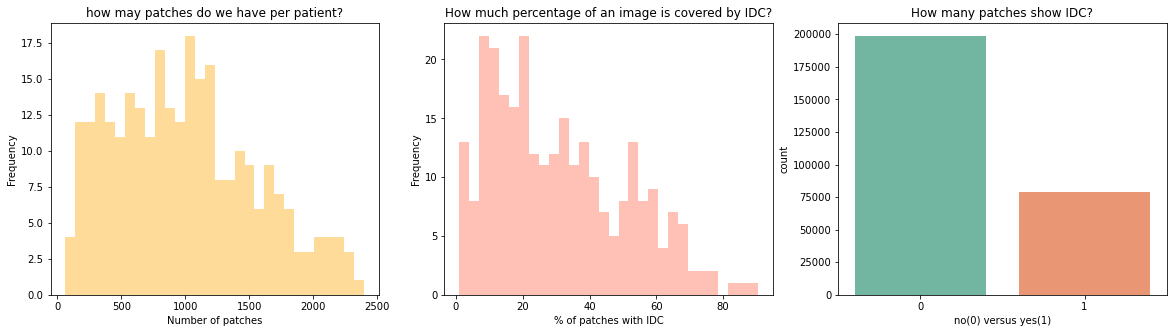

In [12]:
cancer_perc = data.groupby("patient_id").target.value_counts() / data.groupby("patient_id").target.size()
canxer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1, 3,figsize = (20,5))
sns.distplot(data.groupby('patient_id').size(), ax=ax[0], color='Orange', kde=False, bins=30)
ax[0].set_xlabel('Number of patches')
ax[0].set_ylabel('Frequency')
ax[0].set_title('how may patches do we have per patient?')
sns.distplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="Tomato", kde=False, bins=30)
ax[1].set_title("How much percentage of an image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC");
sns.countplot(data.target, palette="Set2", ax=ax[2]);
ax[2].set_xlabel("no(0) versus yes(1)")
ax[2].set_title("How many patches show IDC?");


### Insights

* The numbe rof image patches per patient varie's a lot.

* Some patients have more than 80 % patches that show IDC! Consequently the tissue is full of cancer or only a part of the breast was covered by the tissue slice that is focused on the IDC cancer. 

* The classes of IDC versus no IDC are imbalanced.

In [13]:
# coverting target to int
data.target = data.target.astype(np.int)

### Displaying Cancer Tissue Samples

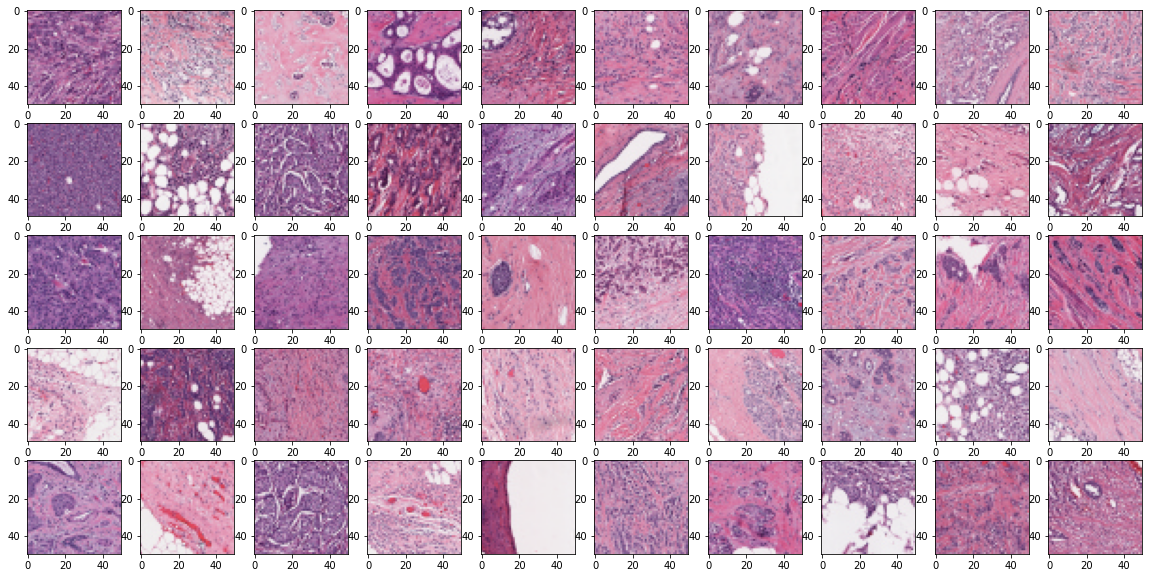

In [14]:
cancer_selection = np.random.choice(data[data.target == 1].index.values, size=50, replace=False)

fig, ax = plt.subplots(5, 10, figsize=(20, 10))

for n in range(5):
    for m in range(10):
        idx = cancer_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)


### Displaying Non-Cancer Tissue Samples

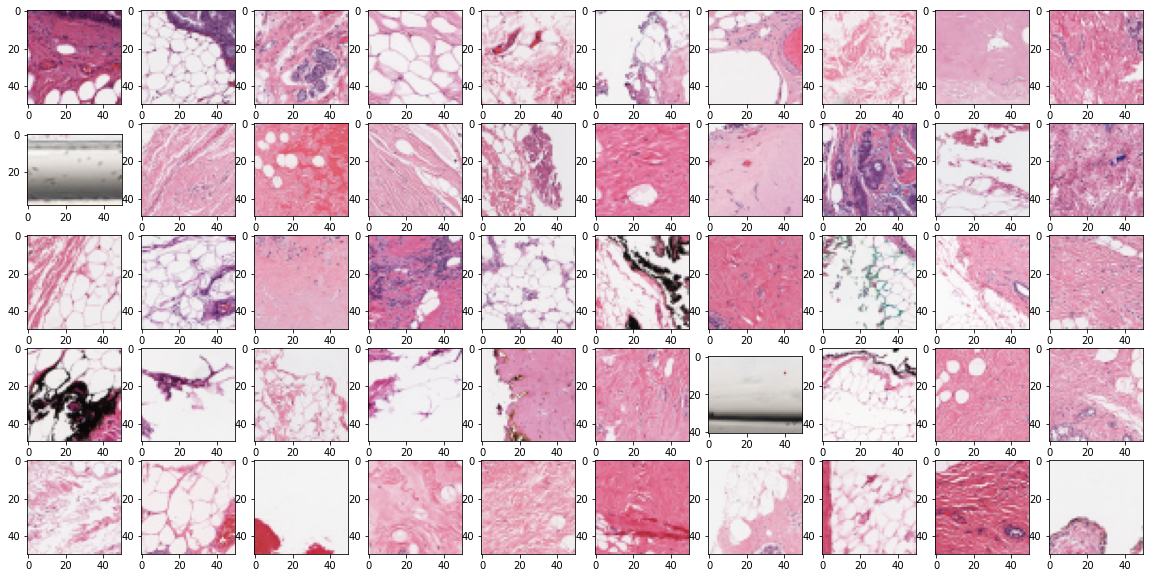

In [15]:
non_cancer_selection = np.random.choice(data[data.target == 0].index.values, size=50, replace=False)

fig, ax = plt.subplots(5, 10, figsize=(20, 10))

for n in range(5):
    for m in range(10):
        idx = non_cancer_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

### Insights

* Cancer Tissur appears to be more viloet.

* But some non-caner tissue is also violet.


## Preparing the dataset

In [16]:
# Creating diresctory to store all images
all_images_dir = 'all_images_dir'

if os.path.isdir(all_images_dir):
    pass
else:
    os.mkdir(all_images_dir)
    


In [ ]:
# This code copies all images from their seperate folders into the same 
# folder called all_images_dir.

'''
The directory structure is like:
    patient_id:
                0
                1
'''

patient_list = folder

for patient in patient_list:
    
    path_0 = "../input/breast-histopathology-images/IDC_regular_ps50_idx5/" + str(patient) + '/0'
    path_1 = "../input/breast-histopathology-images/IDC_regular_ps50_idx5/" + str(patient) + '/1'
    
    # create list of all files in folder 0
    file_list_0 = listdir(path_0)
    
    #create a list of all files in folder 1
    file_list_1 = listdir(path_1)
    
    # moving the 0 class images to all_images_dir
    for fname in file_list_0:
        
        src = os.path.join(path_0, fname)
        dst = os.path.join(all_images_dir, fname)
        shutil.copyfile(src, dst)
        
    # moving the 1 class images to all_images_dir
    for fname in file_list_1:
        
        src = os.path.join(path_1, fname)
        dst = os.path.join(all_images_dir, fname)
        shutil.copyfile(src, dst)
        
    
        

In [ ]:
# Total number of images
len(listdir(all_images_dir))

### Creating dataframe of all images

In [ ]:
image_list = os.listdir('all_images_dir')
df_data = pd.DataFrame(image_list, columns=['image_id'])

df_data.head()

In [ ]:
# Defining helper functions

def extract_patient_id(x):
    
    a = x.split('_')
    patient_id = a[0]
    
    return patient_id

def extract_target(x):
    
    a = x.split('_')
    b = a[4]
    target = b[5]
    
    return target

# creating new column named patient_id
df_data['patient_id'] = df_data['image_id'].apply(extract_patient_id)

#creating new column named target
df_data['target'] = df_data['image_id'].apply(extract_target)

df_data.head(10)

    

In [ ]:
# class distribution of the images

df_data['target'].value_counts()

### Balance the class distribution

* We can see that the class 1 images are higher in number that of class 0

* So to prevent this we balance the dataset

* We do this so that the Neural Network does not lean on favouring only one class 

In [ ]:
SAMPLE_SIZE = 78786

# take a sample of the majority class 0 (total = 198738)
df_0 = df_data[df_data['target'] == '0'].sample(SAMPLE_SIZE, random_state=101)
# take a sample of class 1 (total = 78786)
df_1 = df_data[df_data['target'] == '1'].sample(SAMPLE_SIZE, random_state=101)

# concat the two dataframes
df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)

# Check the new class distribution
df_data['target'].value_counts()

### Creating train and test sets

In [ ]:
y = df_data['target']

df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

### Creating Directory Structure

In [ ]:
# Creating new base directory
base_dir ='base_dir'
os.mkdir(base_dir)

# Creating train directory inside base directory
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# Creating validation directory inside base directory
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

# create new folders inside train_dir
a_no_idc = os.path.join(train_dir, 'a_no_idc')
os.mkdir(a_no_idc)
b_has_idc = os.path.join(train_dir, 'b_has_idc')
os.mkdir(b_has_idc)


# create new folders inside val_dir
a_no_idc = os.path.join(val_dir, 'a_no_idc')
os.mkdir(a_no_idc)
b_has_idc = os.path.join(val_dir, 'b_has_idc')
os.mkdir(b_has_idc)




In [ ]:
# check that the folders have been created
os.listdir('base_dir/train_dir')

In [ ]:
# Set the id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [ ]:
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])

# Transfering the train images
for image in train_list:

    try: 
        fname = image
        target = df_data.loc[image, 'target']

        if target == '0':
            label = 'a_no_idc'
        if target == '1':
            label = 'b_has_idc'

        # source path to image
        src = os.path.join(all_images_dir, fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # move the image from the source to the destination
        shutil.move(src, dst)
    except: 
        continue

for image in val_list:

    try: 
        fname = image
        target = df_data.loc[image,'target']

        if target == '0':
            label = 'a_no_idc'
        if target == '1':
            label = 'b_has_idc'


        # source path to image
        src = os.path.join(all_images_dir, fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # move the image from the source to the destination
        shutil.move(src, dst)

    except:
        continue

        

In [ ]:
# check how many val images we have in each folder
print(len(os.listdir('base_dir/train_dir/a_no_idc')))
print(len(os.listdir('base_dir/train_dir/b_has_idc')))

### Setting up image generators

In [ ]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [ ]:
IMAGE_SIZE = 50

In [ ]:

datagen = ImageDataGenerator(rescale = 1.0 / 255,
                             rotation_range = 90,
                             zoom_range = 0.2,
                             horizontal_flip=True,
                             vertical_flip=True)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

In [ ]:
# Building the model
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                 input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

### Training the model

In [ ]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [ ]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=3, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=50, verbose=1,
                   callbacks=callbacks_list)

try:
    model.save('/kaggle/working/model.h5')
except:
    pass

try:
    model.save('model.h5')
except:
    pass

In [ ]:
model.save('model.h5')

### Evaluating the model

In [ ]:
# get the metric names so we can use evaulate_generator
model.metrics_names

In [ ]:
# Here the best epoch will be used.

model.load_weights('model.h5')

val_loss, val_acc = \
model.evaluate_generator(test_gen, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

### Plotting the training curves

In [ ]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

### Make a prediction on the val set
We need these predictions to calculate the AUC score, print the Confusion Matrix and calculate the F1 score.

In [ ]:
# make a prediction
predictions = model.predict_generator(test_gen, steps=len(df_val), verbose=1)

In [ ]:
predictions.shape

In [ ]:
# This is how to check what index keras has internally assigned to each class. 
test_gen.class_indices

In [ ]:
# Put the predictions into a dataframe.
# The columns need to be oredered to match the output of the previous cell

df_preds = pd.DataFrame(predictions, columns=['no_idc', 'has_idc'])

df_preds.head()

In [ ]:
# Get the true labels
y_true = test_gen.classes

# Get the predicted labels as probabilities
y_pred = df_preds['has_idc']

### Calculating the AUC Score

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true, y_pred)

### Creating the confusion matrix

In [ ]:
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion Matrix',
                         cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
        

In [ ]:
# Get the labels of the test images.

test_labels = test_gen.classes

In [ ]:
test_labels.shape

In [ ]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [ ]:
# Print the label associated with each class
test_gen.class_indices

In [ ]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['a_no_idc', 'b_has_idc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

### Creating a classfifcation Report

In [ ]:
from sklearn.metrics import classification_report

# Generate a classification report

# For this to work we need y_pred as binary labels not as probabilities
y_pred_binary = predictions.argmax(axis=1)

report = classification_report(y_true, y_pred_binary, target_names=cm_plot_labels)

print(report)

**Recall** = Given a class, will the classifier be able to detect it?<br>
**Precision** = Given a class prediction from a classifier, how likely is it to be correct?<br>
**F1 Score** = The harmonic mean of the recall and precision. Essentially, it punishes extreme values.

### Conclusion

* From the above report we can see that the model gives us admirable results.

* The model can be improved.

* The recall for each class should be ideally be above 0.90

* This model can help pathologists detect cancer on tissue faster

* The manual examining of tissue slides would not be required